In [5]:
import yfinance as yf
import pandas as pd
from google.cloud import bigquery

from dotenv import load_dotenv
load_dotenv("/Users/juanluis/Documents/credentials/env.txt")

True

In [6]:
bq_client = bigquery.Client()

In [7]:
series = {'AAPL': 'stock-sentiment-nlp.series.AAPL_series_titles',
 'GS': 'stock-sentiment-nlp.series.GS_series',
 'KHC': 'stock-sentiment-nlp.series.KHC_series',
 'MCD': 'stock-sentiment-nlp.series.MCD_series',
 'MSFT': 'stock-sentiment-nlp.series.MSFT_series',
 'OXY': 'stock-sentiment-nlp.series.OXY_series',
 'PEP': 'stock-sentiment-nlp.series.PEP_series'}

In [8]:
datasets = {}
for ticker, table in series.items():
    sentiment = bq_client.query("SELECT * FROM `stock-sentiment-nlp.series.AAPL_series`").result().to_dataframe().set_index("index").sort_index()
    sentiment.index = list(map(lambda ts : ts.tz_convert(None), sentiment.index))
    
    start_date = sentiment.index.min()
    end_date = sentiment.index.max()
    market = yf.download(ticker, start_date, end_date)
    data = pd.merge(market, sentiment, right_index = True, left_index = True, how = "right" )
    datasets[ticker] = data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [294]:
aapl = datasets["AAPL"]

In [312]:
df = aapl.filter(regex = "star|^Close")
df = df[~df.Close.isna()]

In [314]:
import numpy as np

In [316]:
df.Close.pct_change()

2019-01-02         NaN
2019-01-03   -0.099607
2019-01-04    0.042689
2019-01-07   -0.002226
2019-01-08    0.019063
                ...   
2020-12-23   -0.006976
2020-12-24    0.007712
2020-12-28    0.035766
2020-12-29   -0.013315
2020-12-30   -0.008527
Name: Close, Length: 504, dtype: float64

In [319]:
from matplotlib import pyplot as plt

In [321]:
import seaborn as sns

In [328]:
df["log_return"] = np.log(1 + df.Close.pct_change())

<AxesSubplot:>

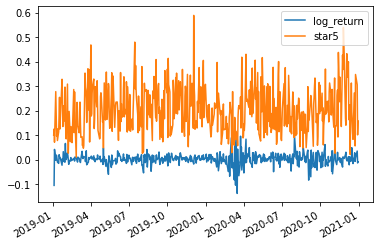

In [333]:
df[["log_return", "star5"]].plot()

In [329]:
df.corr().style.background_gradient(axis = 1)

,Close,star1,star2,star3,star4,star5,log_return
Close,1.000000,0.023738,-0.017578,-0.020513,-0.032387,0.011109,0.047138
star1,0.023738,1.000000,0.624749,-0.203219,-0.846703,-0.759608,-0.084127
star2,-0.017578,0.624749,1.000000,0.377122,-0.736090,-0.826011,-0.049713
star3,-0.020513,-0.203219,0.377122,1.000000,0.150709,-0.425356,0.038528
star4,-0.032387,-0.846703,-0.736090,0.150709,1.000000,0.576150,0.070658
star5,0.011109,-0.759608,-0.826011,-0.425356,0.576150,1.000000,0.055128
log_return,0.047138,-0.084127,-0.049713,0.038528,0.070658,0.055128,1.000000


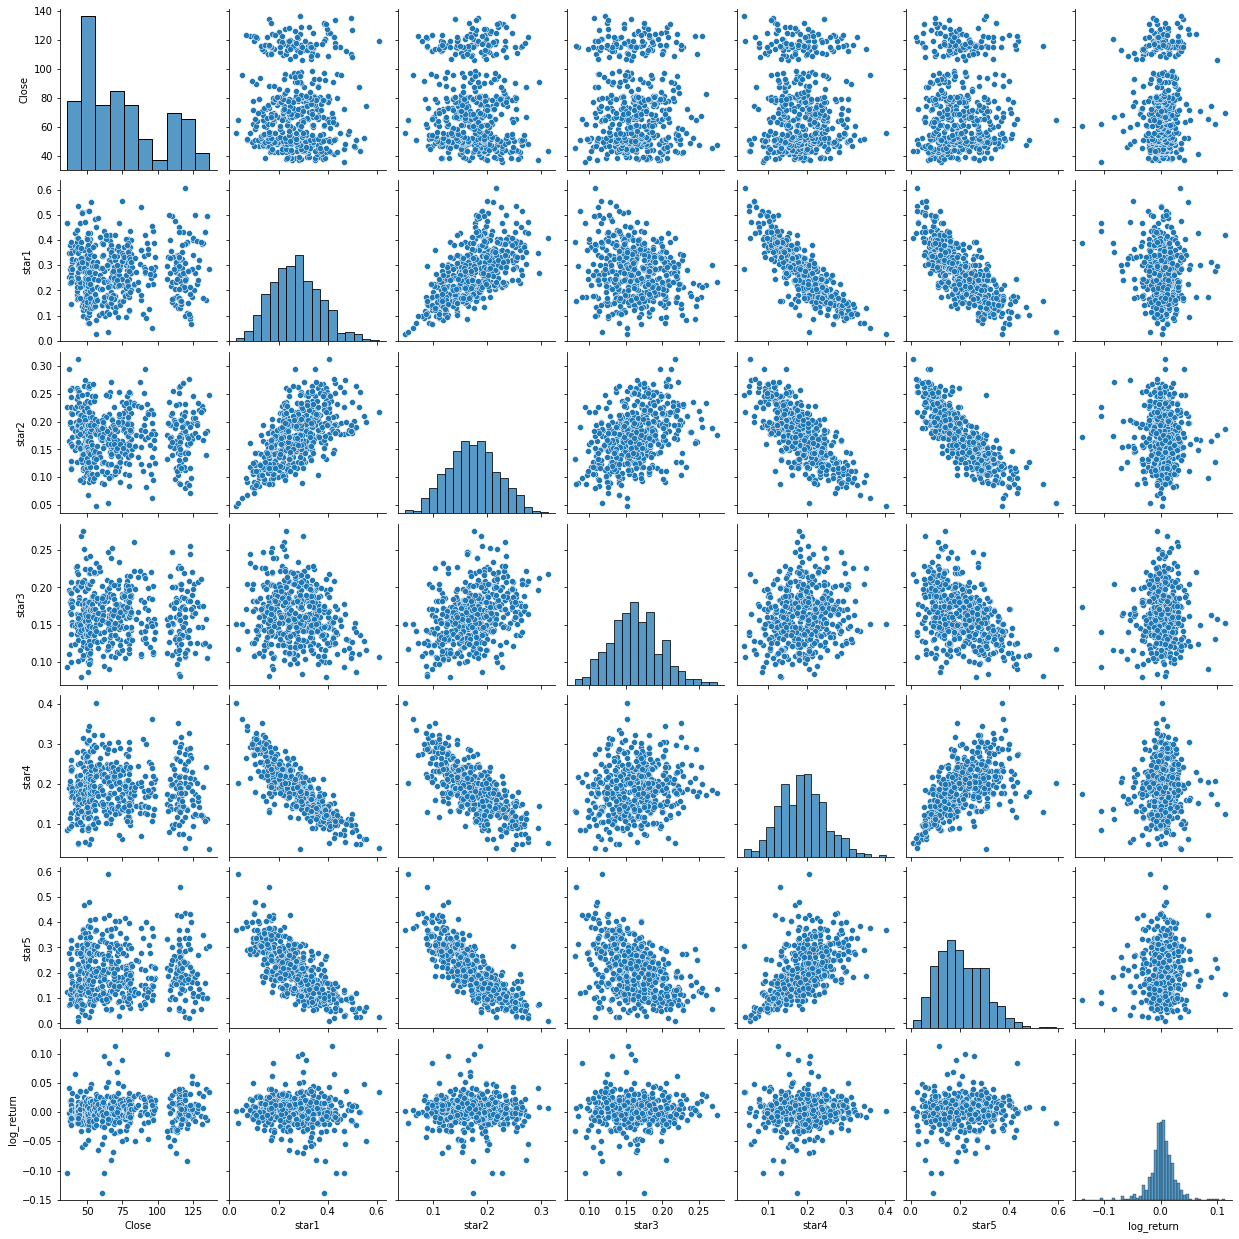

In [330]:
sns.pairplot(df)

In [155]:
from fbprophet import Prophet
m = Prophet()

In [108]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [146]:
def diff(x):
    sign = 1 if x.Open <= x.Close else -1
    return sign * (x.High - x.Low)

In [153]:
aapl.filter(regex = "star|diff").corr().style.background_gradient(axis = 1)

,star1,star2,star3,star4,star5,diff
star1,1.000000,0.607320,-0.214453,-0.833963,-0.732114,-0.007784
star2,0.607320,1.000000,0.379535,-0.706375,-0.823779,0.037658
star3,-0.214453,0.379535,1.000000,0.178285,-0.450663,0.049647
star4,-0.833963,-0.706375,0.178285,1.000000,0.525927,-0.024774
star5,-0.732114,-0.823779,-0.450663,0.525927,1.000000,-0.012754
diff,-0.007784,0.037658,0.049647,-0.024774,-0.012754,1.000000


In [265]:
aapl["diff"] = aapl.apply(diff, axis = 1)

cols = ["Close", "Volume", "star1", "star2", "star3", "star4", "star5"]
df = aapl[cols]

df = pd.merge(df[["Close"]], df.filter(like = "star").shift(1), right_index=True, left_index=True)

import datetime

df = df.bfill()
df["returns"] = df.Close.pct_change()
threshold = datetime.date.fromisoformat("2019-12-31")
train = df.loc[:threshold]
test = df.loc[threshold + datetime.timedelta(days = 1) :]

In [346]:
df = pd.merge(df[["log_return"]], df.filter(like = "star").shift(1), right_index=True, left_index=True)

df = df.bfill()
threshold = datetime.date.fromisoformat("2019-12-31")
train = df.loc[:threshold]
test = df.loc[threshold + datetime.timedelta(days = 1) :]

In [347]:
def rename_cols(df):
    return df.reset_index().rename(columns = {"index" : "ds", "log_return" : "y"}).copy()

In [348]:
train = rename_cols(train)
test  = rename_cols(test)

In [350]:
from fbprophet import Prophet
m = Prophet()
m.add_regressor('star1')
m.add_regressor('star2')
m.add_regressor('star3')
m.add_regressor('star4')
m.add_regressor('star5')


In [351]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -46.3262


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       322.993    0.00084448        98.555      0.7167      0.7167      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       323.053   2.32482e-09       90.9763      0.2133      0.2133      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [352]:
forecast = m.predict(test)

In [357]:
np.corrcoef(forecast.y, forecast.yhat)

array([[1.       , 0.0245527],
       [0.0245527, 1.       ]])

In [353]:
forecast["y"] = test.y

<AxesSubplot:>

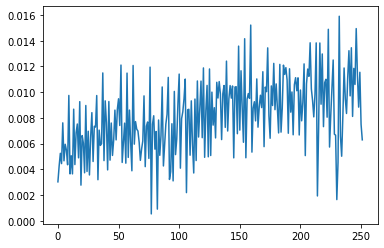

In [359]:
forecast.yhat.plot()


<AxesSubplot:>

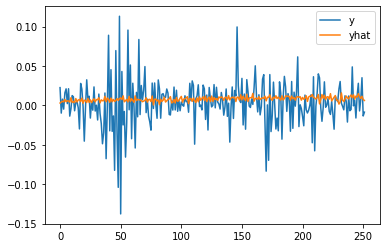

In [354]:
forecast[["y", "yhat"]].plot()

In [122]:
df[["Close", "Volume"]].shift(-1)

,Close,Volume
2019-01-01,39.480000,148158800.0
2019-01-02,35.547501,365248800.0
2019-01-03,37.064999,234428400.0
2019-01-04,NaN,NaN
2019-01-05,NaN,NaN
...,...,...
2020-12-27,136.690002,124486200.0
2020-12-28,134.869995,121047300.0
2020-12-29,133.720001,96452100.0
2020-12-30,NaN,NaN


In [110]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR


macrodata = sm.datasets.macrodata.load_pandas().data
data = macrodata.iloc[:, 2:4]
data.tail(2)

,realgdp,realcons
201,12901.504,9189.0
202,12990.341,9256.0


In [114]:


path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)
# summarize shape
print(df.shape)
# show first few rows
print(df.head())

(108, 2)
     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


In [100]:
import pickle
with open("/Users/juanluis/Documents/ML_Project_Stock_price_Prediction/train_news_data", 'rb') as f:
    file = pickle.load(f)

In [292]:
aapl.pct_change()

,Open,High,Low,Close,Adj Close,Volume,star1,star2,star3,star4,star5,diff
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0.721250,1.343212,0.310181,-0.548903,-0.688352,NaN
2019-01-03,-0.070437,-0.082657,-0.079297,-0.099607,-0.099607,1.465252,0.293338,-0.126817,-0.472213,-0.132490,0.246596,-1.805193
2019-01-04,0.003820,0.019421,0.012676,0.042689,0.042689,-0.358168,-0.256083,0.297897,1.082555,0.041295,-0.430648,-2.276881
2019-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003403,-0.374094,-0.259831,0.787425,1.288477,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.361117,0.047673,0.080526,-0.033408,1.756556,0.000000
2020-12-28,0.020332,0.029072,0.018383,0.035766,0.035766,1.266266,0.078682,0.049775,-0.315992,-0.672891,0.496384,0.622882
2020-12-29,0.030301,0.010558,0.006217,-0.013315,-0.013315,-0.027625,0.732378,-0.259377,-0.130248,1.981812,-0.669449,-2.161879
2020-12-30,-0.017892,-0.020174,-0.006997,-0.008527,-0.008527,-0.203187,-0.134181,-0.025199,0.183839,-0.045576,0.562985,-0.417975


In [83]:

from fbprophet import Prophet

train_size = 252*3                     # Use 3 years of data as train set
val_size = 252                         # Use 1 year of data as validation set
train_val_size = train_size + val_size # Size of train+validation set
i = train_val_size                     # Day to forecast
H = 21                                 # Forecast horizon

# Fit prophet model
m = Prophet()
m.fit(aapl[i-train_val_size:i])

# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(periods=2*H)

# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

# Predict
forecast = m.predict(future)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [77]:
aapl.corr().style.background_gradient(axis = 1)

,Open,High,Low,Close,Adj Close,Volume,star1,star2,star3,star4,star5
Open,1.000000,0.999453,0.999219,0.998688,0.998686,0.141304,0.025528,-0.018373,-0.022609,-0.032558,0.010475
High,0.999453,1.000000,0.999030,0.999301,0.999315,0.155985,0.027009,-0.016376,-0.021486,-0.034156,0.008525
Low,0.999219,0.999030,1.000000,0.999342,0.999329,0.124475,0.022838,-0.018936,-0.020876,-0.031129,0.012071
Close,0.998688,0.999301,0.999342,1.000000,0.999990,0.139226,0.023738,-0.017578,-0.020513,-0.032387,0.011109
Adj Close,0.998686,0.999315,0.999329,0.999990,1.000000,0.139923,0.023526,-0.017877,-0.020505,-0.032147,0.011326
Volume,0.141304,0.155985,0.124475,0.139226,0.139923,1.000000,0.170144,0.110799,-0.018215,-0.133694,-0.143802
star1,0.025528,0.027009,0.022838,0.023738,0.023526,0.170144,1.000000,0.607320,-0.214453,-0.833963,-0.732114
star2,-0.018373,-0.016376,-0.018936,-0.017578,-0.017877,0.110799,0.607320,1.000000,0.379535,-0.706375,-0.823779
star3,-0.022609,-0.021486,-0.020876,-0.020513,-0.020505,-0.018215,-0.214453,0.379535,1.000000,0.178285,-0.450663
star4,-0.032558,-0.034156,-0.031129,-0.032387,-0.032147,-0.133694,-0.833963,-0.706375,0.178285,1.000000,0.525927


In [57]:
sentiment.index

,star1,star2,star3,star4,star5
2019-07-07,NaN,NaN,NaN,NaN,NaN
2019-09-01,NaN,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN,NaN,NaN
2020-07-04,NaN,NaN,NaN,NaN,NaN
2019-12-14,0.143808,0.130184,0.179283,0.229996,0.316729
...,...,...,...,...,...
2020-10-30,0.330561,0.156033,0.140753,0.161783,0.210869
2020-10-07,0.330035,0.173346,0.122401,0.162511,0.211708
2020-04-14,0.095117,0.110280,0.204695,0.305242,0.284666
2020-10-16,0.237886,0.183015,0.185355,0.201870,0.191874


In [54]:
market.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=505, freq=None)

In [45]:
end_date

Timestamp('2020-12-31 00:00:00')

In [44]:
start_date

Timestamp('2019-01-01 00:00:00')

In [35]:
t = sentiment.index[0]


In [40]:
sentiment.index.apply(True)

AttributeError: 'DatetimeIndex' object has no attribute 'apply'

In [18]:
s = aapl.set_index("index").corr().style

In [20]:
s.

,star1,star2,star3,star4,star5
star1,1.000000,0.607320,-0.214453,-0.833963,-0.732114
star2,0.607320,1.000000,0.379535,-0.706375,-0.823779
star3,-0.214453,0.379535,1.000000,0.178285,-0.450663
star4,-0.833963,-0.706375,0.178285,1.000000,0.525927
star5,-0.732114,-0.823779,-0.450663,0.525927,1.000000


<AxesSubplot:>

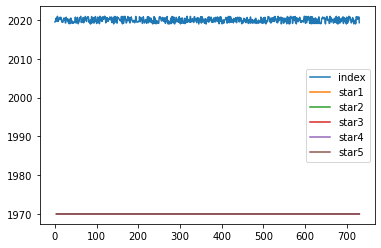

In [9]:
aapl.plot()